<a href="https://colab.research.google.com/github/Imposon/Clinical_No_show/blob/main/ai_ml_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joniarroba/noshowappointments")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'noshowappointments' dataset.
Path to dataset files: /kaggle/input/noshowappointments


In [3]:
import os

print("Downloaded path:", path)
print("Files inside path:", os.listdir(path))


Downloaded path: /kaggle/input/noshowappointments
Files inside path: ['KaggleV2-May-2016.csv']


In [4]:
df = pd.read_csv(os.path.join(path, "KaggleV2-May-2016.csv"))

In [5]:
print("Original shape:", df.shape)
print(df.head())

Original shape: (110527, 14)
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1        

In [6]:
df.rename(columns={'No-show':'No_show'}, inplace=True)

In [7]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [8]:
df['lead_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df['appointment_dayofweek'] = df['AppointmentDay'].dt.dayofweek

In [9]:
df = df[df['Age'] >= 0]

In [10]:
df['No_show'] = df['No_show'].map({'Yes':1, 'No':0})

In [11]:
df.drop(['PatientId',
         'AppointmentID',
         'ScheduledDay',
         'AppointmentDay',
         'Neighbourhood'], axis=1, inplace=True)

print("Cleaned shape:", df.shape)
df.head()

Cleaned shape: (110526, 11)


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,lead_time,appointment_dayofweek
0,F,62,0,1,0,0,0,0,0,-1,4
1,M,56,0,0,0,0,0,0,0,-1,4
2,F,62,0,0,0,0,0,0,0,-1,4
3,F,8,0,0,0,0,0,0,0,-1,4
4,F,56,0,1,1,0,0,0,0,-1,4


In [12]:
baseline = df['No_show'].mean()
print("Baseline No-show rate:", baseline)

Baseline No-show rate: 0.20193438647919945


In [13]:
df['Gender'] = df['Gender'].map({'F':0, 'M':1})

In [14]:
df['age_group'] = pd.cut(
    df['Age'],
    bins=[-1,12,18,35,60,200],
    labels=[0,1,2,3,4],
    include_lowest=True
)

df['age_group'] = df['age_group'].astype(int)

In [15]:
df['lead_time_bucket'] = pd.cut(
    df['lead_time'],
    bins=[-1000,0,3,7,30,1000],
    labels=[0,1,2,3,4],
    include_lowest=True
)

df['lead_time_bucket'] = df['lead_time_bucket'].astype(int)

In [16]:
df['sms_lead_interaction'] = df['SMS_received'] * df['lead_time']

In [17]:
df['is_weekend'] = df['appointment_dayofweek'].isin([5,6]).astype(int)

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('No_show', axis=1)
y = df['No_show']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (88420, 14)
Test shape: (22106, 14)


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [20]:
#Testing for Logistic Regression

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

log_probs = log_model.predict_proba(X_test_scaled)[:,1]
log_preds = log_model.predict(X_test_scaled)

print("Logistic ROC-AUC:", roc_auc_score(y_test, log_probs))
print(classification_report(y_test, log_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_preds))

Logistic ROC-AUC: 0.7060004326389575
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17642
           1       0.34      0.01      0.02      4464

    accuracy                           0.80     22106
   macro avg       0.57      0.50      0.45     22106
weighted avg       0.71      0.80      0.71     22106

Confusion Matrix:
 [[17557    85]
 [ 4420    44]]


In [21]:
#Testing for RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_probs = rf_model.predict_proba(X_test)[:,1]
rf_preds = rf_model.predict(X_test)

print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_probs))
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

Random Forest ROC-AUC: 0.7300947224345292
              precision    recall  f1-score   support

           0       0.91      0.57      0.70     17642
           1       0.31      0.77      0.45      4464

    accuracy                           0.61     22106
   macro avg       0.61      0.67      0.57     22106
weighted avg       0.79      0.61      0.65     22106

Confusion Matrix:
 [[10116  7526]
 [ 1030  3434]]


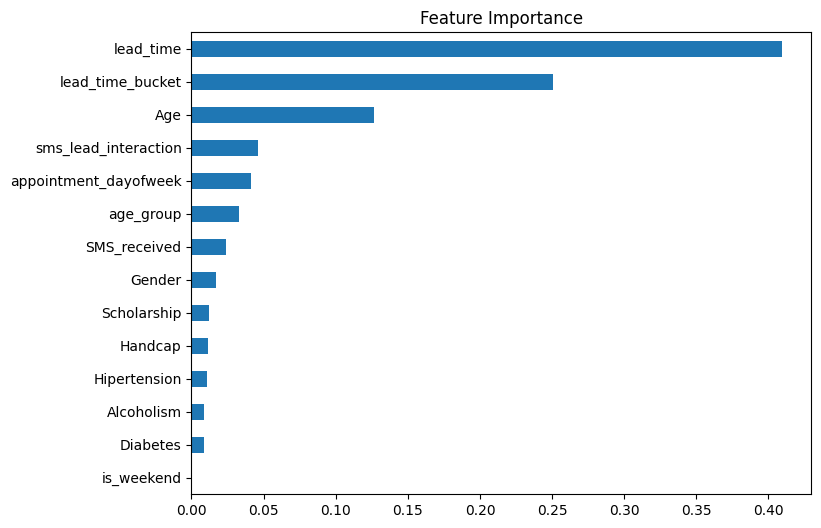

In [22]:
import matplotlib.pyplot as plt

importance = pd.Series(rf_model.feature_importances_, index=X.columns)
importance = importance.sort_values()

plt.figure(figsize=(8,6))
importance.plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [23]:
import joblib
joblib.dump(rf_model, "noshow_model.pkl")

['noshow_model.pkl']